In [1]:
# libraries 
import os
import glob
import fnmatch
import pandas as pd 
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import scipy.io
import scipy.io.wavfile
import tensorflow as tf
import wave
from IPython.display import Audio
from scipy.io.wavfile import write

# libraries for training models
#import keras

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [2]:
path_data = 'C:\\Users\\markereversey\\Desktop\\project-AI\\Dataset\\'
Newbroncho_vesi = pd.read_excel(path_data + 'Newbroncho-vesi.xlsx', header=None)
Newcoarsecrackles = pd.read_excel(path_data + 'Newcoarsecrackles.xlsx', header=None)
Newfinecrackles = pd.read_excel(path_data + 'Newfinecrackles.xlsx', header=None)
NewPleural = pd.read_excel(path_data + 'NewPleural.xlsx', header=None)
Newrhonchi = pd.read_excel(path_data + 'Newrhonchi.xlsx', header=None)
Newstridor = pd.read_excel(path_data + 'Newstridor.xlsx', header=None)
Newvesicular = pd.read_excel(path_data + 'Newvesicular.xlsx', header=None)
Unlabels = pd.read_excel(path_data + 'x.xlsx', header=None)

# Data Visualization

([<matplotlib.patches.Wedge at 0x2f624f9bf90>,
 [Text(1.4954078341020671, 0.6973201629855289, 'Newbroncho_vesi'),
  Text(0.42705132493900555, 1.5937776400325863, 'Newcoarsecrackles'),
  Text(-0.9464012605858947, 1.3516007746229763, 'Newfinecrackles'),
  Text(-1.643721272795644, 0.14380673613940548, 'NewPleural'),
  Text(-1.1667259704842043, -1.1667264074313615, 'Newrhonchi'),
  Text(0.14380735172456444, -1.6437212189388954, 'Newvesicular'),
  Text(1.3516011290568049, -0.9464007544018395, 'Newstridor'),
  Text(1.6437212938333738, -0.14380649567644657, 'Unlabels')],
 [Text(0.8156770004193092, 0.3803564525375612, '14%'),
  Text(0.2329370863303666, 0.8693332581995924, '14%'),
  Text(-0.5162188694104879, 0.7372367861579869, '14%'),
  Text(-0.8965752397067147, 0.07844003789422116, '14%'),
  Text(-0.636395983900475, -0.636396222235288, '14%'),
  Text(0.07844037366794424, -0.8965752103303064, '14%'),
  Text(0.7372369794855298, -0.5162185933100941, '14%'),
  Text(0.8965752511818401, -0.07843990

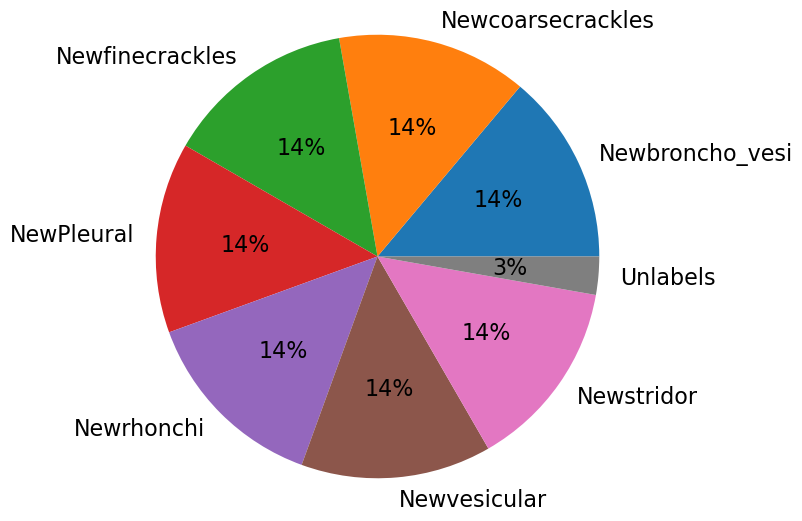

In [20]:
info = np.array([len(Newbroncho_vesi.columns[1:]), len(Newcoarsecrackles.columns[1:]), len(Newfinecrackles.columns[1:]),
                 len(NewPleural.columns[1:]), len(Newrhonchi.columns[1:]), len(Newstridor.columns[1:]),
                 len(Newvesicular.columns[1:]), len(Unlabels.columns[1:])])
labels = ['Newbroncho_vesi', 'Newcoarsecrackles', 'Newfinecrackles', 
          'NewPleural', 'Newrhonchi', 'Newvesicular', 'Newstridor'
          ,'Unlabels']

plt.pie(info, labels=labels, autopct='%.0f%%', radius=1.5, textprops={'fontsize':16} )

# Dataset test

In [3]:
Newbroncho_vesi = pd.read_excel(path_data + 'Newbroncho-vesi.xlsx', header=None, skiprows=1)

In [4]:
Newbroncho_vesi

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.000023,0.000275,0.003632,-0.010865,0.002136,-0.008087,-0.008820,-0.001038,0.008728,-0.009003,...,-0.000214,-0.000031,-0.000061,-0.000153,-0.000580,-0.000031,-0.000092,0.000031,-0.000305,0.000183
1,0.000045,0.000885,0.003388,-0.010865,0.002075,-0.008209,-0.008301,-0.000793,0.008606,-0.008850,...,-0.000244,-0.000061,-0.000061,-0.000153,-0.000549,-0.000061,-0.000092,0.000061,-0.000366,0.000153
2,0.000068,0.001373,0.003204,-0.010865,0.001862,-0.007935,-0.007752,-0.000488,0.008026,-0.008728,...,-0.000275,-0.000061,-0.000061,-0.000153,-0.000519,-0.000061,-0.000122,0.000092,-0.000427,0.000122
3,0.000091,0.002045,0.003082,-0.010865,0.001679,-0.007630,-0.007355,0.000031,0.007843,-0.008820,...,-0.000275,-0.000092,-0.000092,-0.000153,-0.000519,-0.000061,-0.000153,0.000092,-0.000458,0.000122
4,0.000113,0.002625,0.002960,-0.010712,0.001617,-0.007508,-0.006897,0.000366,0.007904,-0.008789,...,-0.000305,-0.000092,-0.000122,-0.000153,-0.000488,-0.000061,-0.000183,0.000092,-0.000458,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112450,2.549909,0.002319,0.001831,-0.022797,-0.000397,-0.004395,0.018250,0.001160,-0.009552,0.004578,...,0.000214,0.009033,-0.002808,-0.025208,-0.001526,0.004059,0.000946,0.010285,0.007752,0.004242
112451,2.549932,0.001831,0.001648,-0.022950,0.001007,-0.003632,0.017396,0.001251,-0.010224,0.004669,...,0.000122,0.008576,-0.003418,-0.024812,-0.001770,0.003967,0.001404,0.011017,0.007172,0.004425
112452,2.549955,0.001221,0.001556,-0.023225,0.002594,-0.002777,0.016327,0.001465,-0.011078,0.005097,...,0.000000,0.008118,-0.004059,-0.024262,-0.001984,0.003815,0.001862,0.011658,0.006592,0.004578
112453,2.549977,0.000580,0.001404,-0.023591,0.004181,-0.002075,0.014985,0.001801,-0.012116,0.005402,...,-0.000061,0.007538,-0.004700,-0.023560,-0.002167,0.003723,0.002258,0.012238,0.005951,0.004700


# Any Function

In [5]:
def random_audio(data : 'array') -> object:
    random_col_name = data.sample(axis=1).columns[0] 
    random_col_data = data[random_col_name]
    return random_col_data, random_col_name

In [102]:
def generate_audio(data : 'array', file_name : str) -> object:
    l = []
    folder = file_name 
    for col in data.columns[1:]:
        l.append(data.iloc[:, col])
        if not os.path.exists(folder):
            os.makedirs(folder)
        file_path = os.path.join(folder, 'output_'+file_name+str(col)+'.wav')
        write(file_path, 10000, l[col-1])


In [100]:
def generate_wav(data : 'array', name) -> object:
    plt.plot(data)
    plt.title(f'Column : {name}.wav')
    plt.xlabel('itme')
    plt.ylabel('amplitude')
    plt.show()

In [95]:
newbrocho_column, name = random_audio(Newbroncho_vesi)
newbrocho_column, name

(0        -0.000031
 1        -0.000061
 2        -0.000061
 3        -0.000092
 4        -0.000092
             ...   
 112450    0.009033
 112451    0.008576
 112452    0.008118
 112453    0.007538
 112454    0.006928
 Name: 22, Length: 112455, dtype: float64,
 22)

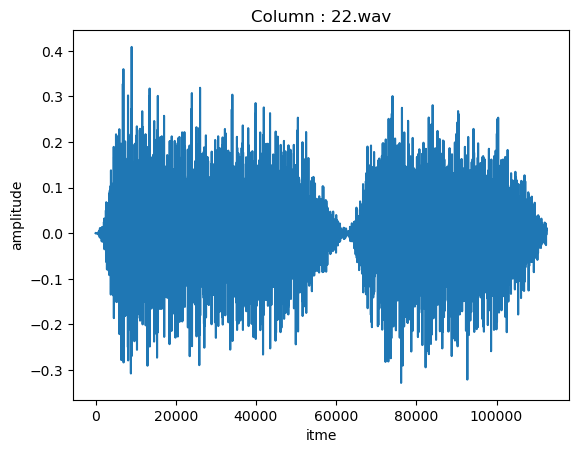

In [96]:
generate_wav(newbrocho_column, name)

In [97]:
Audio(data=newbrocho_column, rate=10000)

# example idea


In [66]:
l = []
folder = 'newbrocho'
for col in Newbroncho_vesi.columns[1:]:
    l.append(Newbroncho_vesi.iloc[:, col])
    if not os.path.exists(folder):
        os.makedirs(folder)
    file_path = os.path.join(folder, 'output_newbrocho_'+str(col)+'.wav')
    write(file_path, 10000, l[col-1])


# Create file.wav

In [293]:
generate_audio(Newbroncho_vesi, 'Newbroncho_vesi')
generate_audio(Newcoarsecrackles, 'Newcoarsecrackles')
generate_audio(NewPleural, 'NewPleural')
generate_audio(Unlabels, 'Unlabels')

In [200]:
def random_sound (audio_class):
    random_sound = np.random.randint(0, len(os.listdir(audio_class)))
    sound_file = os.listdir(audio_class)[random_sound]
    sound_file_path = os.path.join(audio_class, sound_file)
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class + sound
    sound, sample_rate = librosa.load(sound)
    return ipd.Audio(sound, rate=sample_rate) , sound, sound_file_path

def show_audio_spectrum (audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0, sample_rate, len(magnitude_normal))
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]
    
    plt.figure(figsize=(12, 8))
    plt.plot(half_freq, half_magnitude)
    plt.title('Spectrum')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.show()

def show_spectrogram (audio_sample):
    hop_length = 512
    n_fft = 2048
    sample_rate = 22050

    hop_length_duration = float(hop_length) / sample_rate
    n_fft_duration = float(n_fft) / sample_rate

    print(f'STFT hop length duration is : {hop_length_duration}')
    print(f'STFT window duration is : {n_fft_duration}')

    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)
    
    # calculate abs value on complex nums to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    plt.figure(figsize=(15, 10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel('time')
    plt.ylabel('frequency')
    plt.colorbar()
    plt.title('spectrogram')

# MFCCs

def show_mfcc_features (audio_sample) :
    hop_length = 512
    n_fft = 2048
    sample_rate = 22050
    sr = librosa.load(librosa.ex('libri1'))
    #MFCCs = librosa.feature.mfcc(audio_sample, n_fft=n_fft, hop_length=hop_length, n_mfcc=52)
    MFCCs = librosa.feature.mfcc(y=audio_sample, n_fft=n_fft, hop_length=hop_length, n_mfcc=52)
    #display MFCCs

    plt.figure(figsize=(15, 10))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel('time')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.colorbar()
    plt.title('MFCCs')
    plt.show()
    

In [201]:
# path file.wav
main_path = 'C:\\Users\\markereversey\\Desktop/project-AI/'
Newbroncho_vesi_wav_path = main_path +'/Newbroncho_vesi/'
Newcoarsecrackles_wav_path = main_path + '/Newcoarsecrackles/'
NewPleural_wav_path = main_path + '/NewPleural/'


In [202]:
newbrocho_audio,newbrocho_sample,newbrocho_path = random_sound(Newbroncho_vesi_wav_path)

C:\Users\markereversey\Desktop/project-AI//Newbroncho_vesi/output_Newbroncho_vesi29.wav


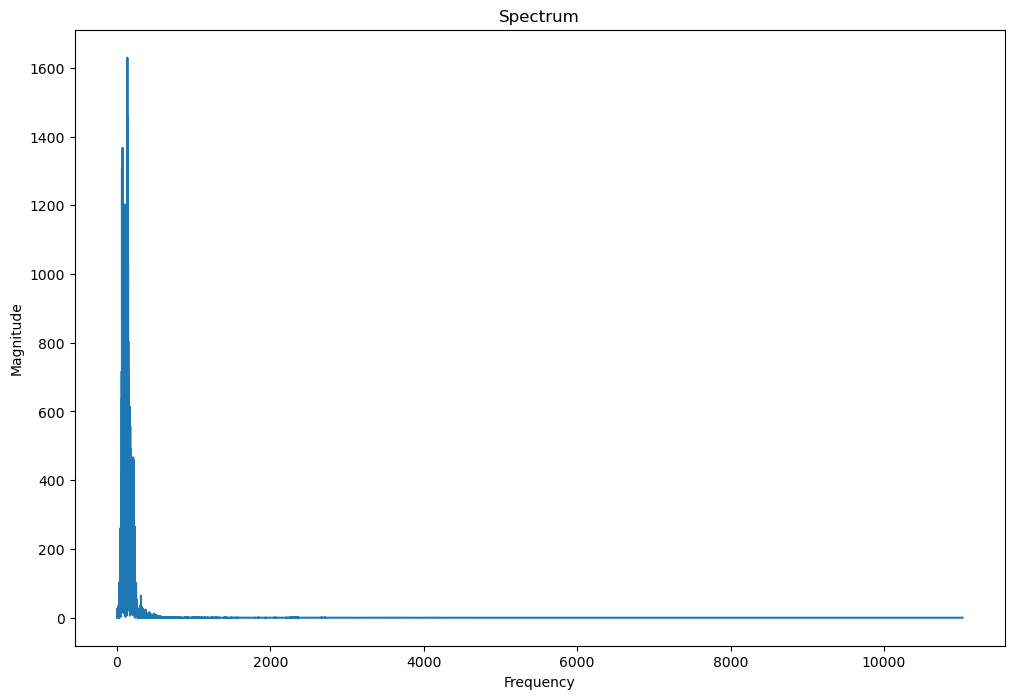

In [203]:
print(newbrocho_path)
show_audio_spectrum(newbrocho_sample)

STFT hop length duration is : 0.023219954648526078
STFT window duration is : 0.09287981859410431


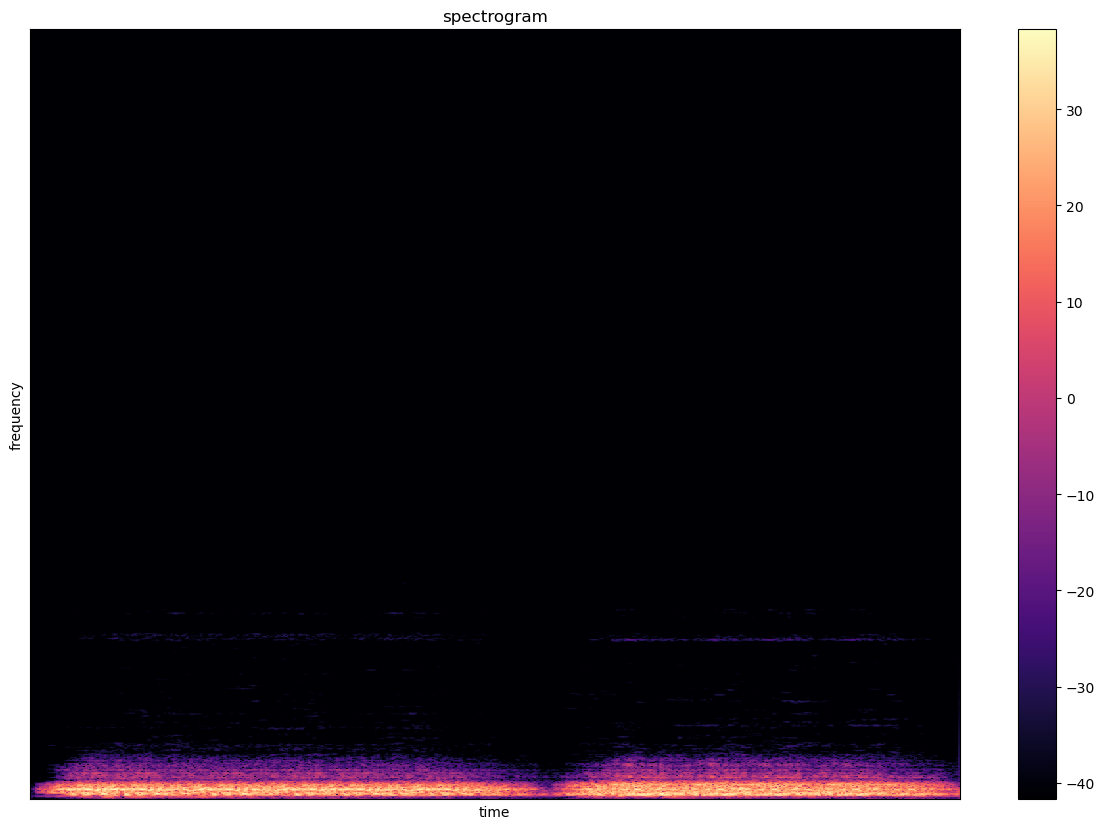

In [204]:
show_spectrogram(newbrocho_sample)

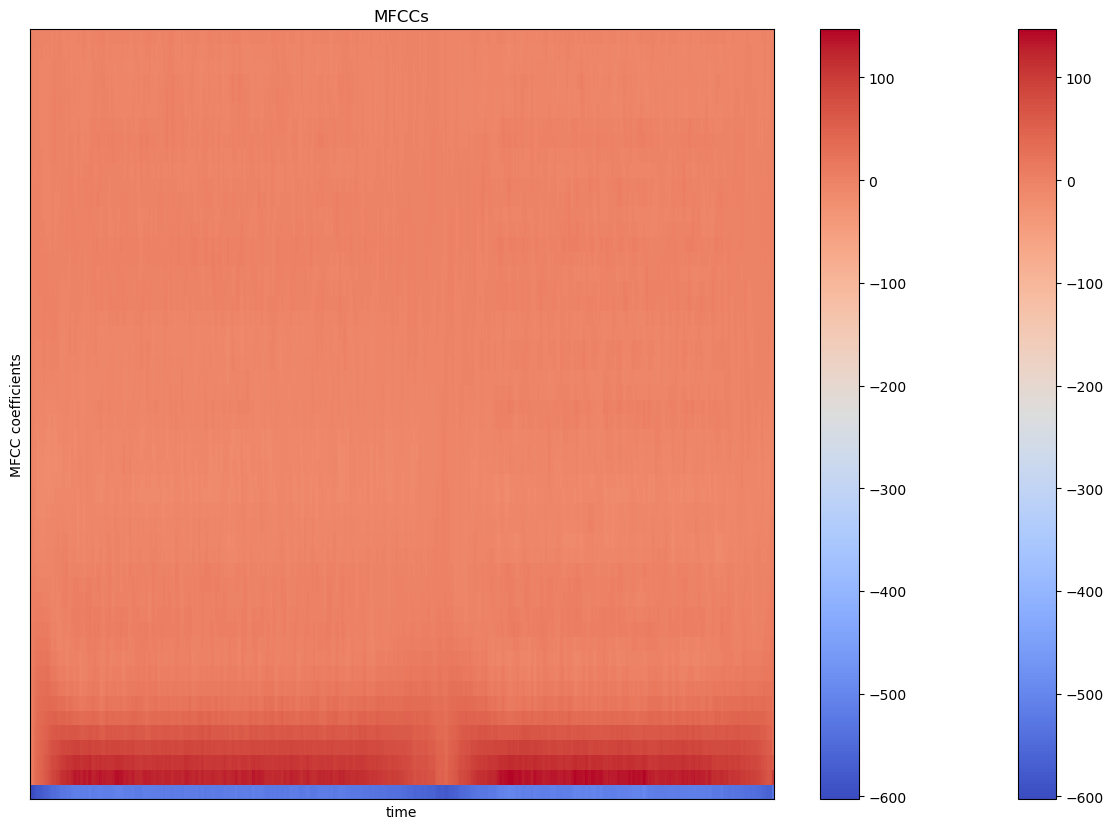

In [205]:
show_mfcc_features(newbrocho_sample)

# Data Preprocessing

In [206]:
def add_noise (data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift (data, x ) :
    return np.roll(data, x)

def stretch (data, rate):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data 

def pitch_shift (data, rate):
    data = librosa.effects.pitch_shift(data, sr=22050, n_steps=rate)
    return data

In [207]:
def load_file_data (folder, file_names, duration=10, sr=22050):

    input_length = sr * duration
    features = 52
    data = []

    for file_name in file_names :
        try:
            sound_file = folder + file_name
            X, sr = librosa.load(sound_file, sr=sr, duration=duration)
            dur= librosa.get_duration(y=X, sr=sr)
            if ( round(dur) < duration):
                print('fixing audio lenght : ', file_name)
                X = librosa.util.fix_length(X, size=input_length)
            
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T, axis=0)
            feature = np.array(mfccs).reshape([-1, 1])
            data.append(feature)
            stretch_data_1 = stretch(X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, 
                                                        n_mfcc=features).T, axis=0)

            feature_1 = np.array(mfccs_stretch_1).reshape([-1, 1])
            data.append(feature_1)
            stretch_data_2 = stretch(X, 1.2)
            
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, 
                                                        n_mfcc=features).T, axis=0)
            feature_2 = np.array(mfccs_stretch_2).reshape([-1, 1])
            data.append(feature_2)
        except Exception as e:
            print('Error encountered while parsing file: ',file_name)


    return data

# Encoding

In [208]:
CLASSES = ['Newbroncho_vesi', 'Newcoarsecrackles', 'NewPleural']

NB_CLASSES = len(CLASSES)

label_to_int = {k : v for v, k in enumerate(CLASSES)}
print(label_to_int,'\n')

int_to_label  = {v : k for k, v in label_to_int.items()}
print(int_to_label)



{'Newbroncho_vesi': 0, 'Newcoarsecrackles': 1, 'NewPleural': 2} 

{0: 'Newbroncho_vesi', 1: 'Newcoarsecrackles', 2: 'NewPleural'}


In [209]:
SAMPLE_RATE = 22050
MAX_SOUND_CLIP_DURATION = 10 # 10 sec / clip


Newbroncho_vesi_files = fnmatch.filter(os.listdir(Newbroncho_vesi_wav_path), 'output_Newbroncho_vesi*.wav')
Newbroncho_vesi_sounds = load_file_data(folder=Newbroncho_vesi_wav_path,
                                        file_names=Newbroncho_vesi_files,
                                        duration=MAX_SOUND_CLIP_DURATION)
Newbroncho_vesi_labels = [0 for items in Newbroncho_vesi_sounds]


Newcoarsecrackles_files = fnmatch.filter(os.listdir(Newcoarsecrackles_wav_path), 'output_Newcoarsecrackles*.wav')
Newcoarsecrackles_sounds= load_file_data(folder=Newcoarsecrackles_wav_path,
                                        file_names=Newcoarsecrackles_files,
                                        duration=MAX_SOUND_CLIP_DURATION)
Newcoarsecrackles_labels = [1 for items in Newcoarsecrackles_sounds]


NewPleural_files = fnmatch.filter(os.listdir(NewPleural_wav_path), 'output_NewPleural*.wav')
NewPleural_sounds= load_file_data(folder=NewPleural_wav_path,
                                        file_names=NewPleural_files,
                                        duration=MAX_SOUND_CLIP_DURATION)
NewPleural_labels = [2 for items in NewPleural_sounds]



fixing audio lenght :  output_NewPleural1.wav
fixing audio lenght :  output_NewPleural10.wav
fixing audio lenght :  output_NewPleural11.wav
fixing audio lenght :  output_NewPleural12.wav
fixing audio lenght :  output_NewPleural13.wav
fixing audio lenght :  output_NewPleural14.wav
fixing audio lenght :  output_NewPleural15.wav
fixing audio lenght :  output_NewPleural16.wav
fixing audio lenght :  output_NewPleural17.wav
fixing audio lenght :  output_NewPleural18.wav
fixing audio lenght :  output_NewPleural19.wav
fixing audio lenght :  output_NewPleural2.wav
fixing audio lenght :  output_NewPleural20.wav
fixing audio lenght :  output_NewPleural21.wav
fixing audio lenght :  output_NewPleural22.wav
fixing audio lenght :  output_NewPleural23.wav
fixing audio lenght :  output_NewPleural24.wav
fixing audio lenght :  output_NewPleural25.wav
fixing audio lenght :  output_NewPleural26.wav
fixing audio lenght :  output_NewPleural27.wav
fixing audio lenght :  output_NewPleural28.wav
fixing audio le

# Create unlabel for training

# Concatenation

In [214]:
x_data = np.concatenate((Newbroncho_vesi_sounds, Newcoarsecrackles_sounds, NewPleural_sounds))
print(x_data, '\n' ,'-'*50)
y_data = np.concatenate((Newbroncho_vesi_labels, Newcoarsecrackles_labels, NewPleural_labels))
print(y_data)

print(f'combined training data record : {len(x_data), len(y_data)}')

[[[-4.5113297e+02]
  [ 1.0604915e+02]
  [ 8.5974327e+01]
  ...
  [-3.8509240e+00]
  [-2.7607985e+00]
  [ 1.7122092e+00]]

 [[-4.7449683e+02]
  [ 9.9327621e+01]
  [ 8.2586182e+01]
  ...
  [-3.7612240e+00]
  [-2.7449195e+00]
  [ 1.4356763e+00]]

 [[-4.7284174e+02]
  [ 9.8087143e+01]
  [ 8.2331207e+01]
  ...
  [-3.6592603e+00]
  [-2.6214120e+00]
  [ 1.3151908e+00]]

 ...

 [[-4.1521078e+02]
  [ 1.0074411e+02]
  [ 2.5224552e+01]
  ...
  [ 4.0035203e-01]
  [-4.5875892e-01]
  [ 1.6917968e-01]]

 [[-4.4687473e+02]
  [ 9.3990494e+01]
  [ 2.8529627e+01]
  ...
  [ 4.1030800e-01]
  [-4.1368490e-01]
  [ 5.0270088e-02]]

 [[-4.4780811e+02]
  [ 9.6164093e+01]
  [ 2.8150146e+01]
  ...
  [ 3.8662174e-01]
  [-6.6979247e-01]
  [-7.3849894e-02]]] 
 --------------------------------------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 

# Data Split

In [277]:
x_train , x_test, y_trian, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=4, shuffle=True)
x_train , x_val, y_trian, y_val = train_test_split(x_train, y_trian, train_size=0.9, random_state=4, shuffle=True)


y_trian =  np.array(tf.keras.utils.to_categorical(y_trian, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))

# Imbalanced data
กรณีนี้มี Data ที่ถูก balanced data มาแล้วเป็น 30 

In [278]:
# class weight

TRAIN_IMG_COUNT = 90
COUNT_0 =COUNT_1 = COUNT_2 = 30    


# W =  all_img_train / (N * number_img)

weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)

class_weight = {0 : weight_for_0, 1 : weight_for_1 , 2 : weight_for_2}
class_weight

{0: 1.0, 1: 1.0, 2: 1.0}

In [279]:
x_train_lstm = x_train
x_val_lstm = x_test
x_test_lstm = x_val 

y_trian_lstm = y_trian
y_val_lstm = y_test
y_test_lstm = y_val

In [280]:
lstm_model = tf.keras.models.Sequential()

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(128))

lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(3, activation='softmax'))
lstm_model.summary()

c:\Users\markereversey\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 52, 1024)       │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 26, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 26, 512)        │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 13, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 7, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,630,019 (13.85 MB)

 Trainable params: 3,626,435 (13.83 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [281]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimiser, 
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

cb = [EarlyStopping(patience=15, monitor='val_accuracy', mode='max', 
                    restore_best_weights=True), 
                    ModelCheckpoint('./checkpoint/aj_lstm_cnn.keras', save_best_only=True)]


In [282]:
callbacks = [ 
    TensorBoard(log_dir='./logs')
]
history = lstm_model.fit(x_train_lstm, y_trian_lstm,
                         validation_data=(x_val_lstm, y_val_lstm),
                         batch_size = 8, 
                         epochs=150,
                         class_weight=None,
                         callbacks= cb)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.6709 - loss: 0.9250 - val_accuracy: 0.6667 - val_loss: 1.0299
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8076 - loss: 0.6855 - val_accuracy: 1.0000 - val_loss: 0.8526
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9216 - loss: 0.4487 - val_accuracy: 1.0000 - val_loss: 0.7149
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9734 - loss: 0.3539 - val_accuracy: 0.7407 - val_loss: 0.5520
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9693 - loss: 0.2237 - val_accuracy: 0.7407 - val_loss: 0.4150
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9500 - loss: 0.2248 - val_accuracy: 0.6667 - val_loss: 0.6991
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9922 - loss: 0.1238 - val_accuracy: 0.6667 - val_loss: 0.4672
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9731 - loss: 0.1411 - val_accuracy: 0.

# Evaluate Model

In [283]:
lstm_model.evaluate(x_val_lstm, y_val_lstm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.8451


[0.852565348148346, 1.0]

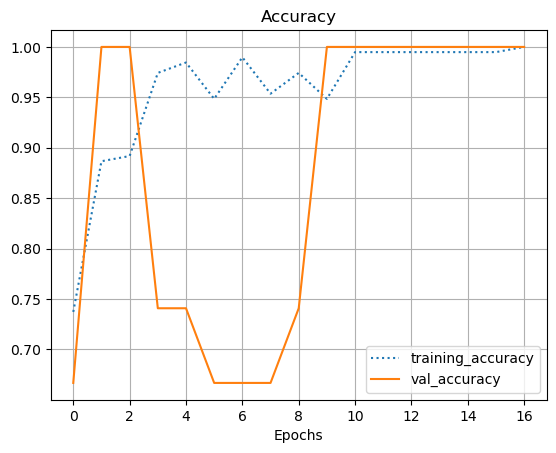

In [284]:
def plot_loss_curves (history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))


    plt.figure()
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy', linestyle='dotted')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


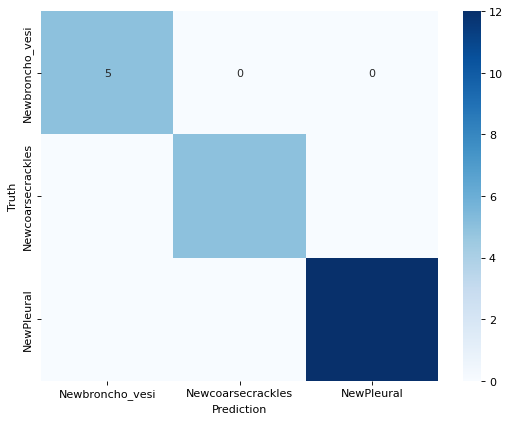

In [285]:
classes = ['Newbroncho_vesi', 'Newcoarsecrackles', 'NewPleural']

preds = lstm_model.predict(x_test_lstm)
classpreds = [np.argmax(t) for t in preds]
y_testclass = [np.argmax(t) for t in y_test_lstm]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [286]:
cm

array([[ 5,  0,  0],
       [ 0,  5,  0],
       [ 0,  0, 12]], dtype=int64)

In [287]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                   precision    recall  f1-score   support

  Newbroncho_vesi       1.00      1.00      1.00         5
Newcoarsecrackles       1.00      1.00      1.00         5
       NewPleural       1.00      1.00      1.00        12

         accuracy                           1.00        22
        macro avg       1.00      1.00      1.00        22
     weighted avg       1.00      1.00      1.00        22



In [288]:
def prediction (file_path, duration=10, sr=22050):
    classes = ['Newbroncho_vesi', 'Newcoarsecrackles', 'NewPleural']
    input_length = sr * duration

    X, sr = librosa.load(file_path, sr=sr, duration=duration)
    dur = librosa.get_duration(y=X, sr=sr)

    if (round(dur) < duration):
        X = librosa.util.fix_length(X, size=input_length)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=52, n_fft=512, hop_length=2048).T, axis=0)
    mfccs = mfccs.reshape(1, mfccs.shape[0], 1)
    preds = lstm_model.predict(mfccs)

    preds_class_index = np.argmax(preds)
    preds_class = classes[preds_class_index]
    confidence = preds[0, preds_class_index]

    return preds_class, confidence


In [289]:
newcoarsecrackles_audio,newcoarsecrackles_sample,newcoarsecrackles_path = random_sound(Newcoarsecrackles_wav_path)
newpleural_audio, newpleural_sample, newpleural_path = random_sound(NewPleural_wav_path)

In [291]:
prediction(file_path=newcoarsecrackles_path,
                 duration=10,
                )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


('Newcoarsecrackles', 0.3576304)